# Pipeline für die Regression
in diesem Notebook werden die Methoden die in dem Notebook XYZ entwickelt wurden nun innerhalb einer Pipeline umgesetzt. Diese Pipeline ist für die Insurance risk. Daher wird unmittelbar nach dem Laden der Daten, das Dataframe horizontal und vertikal entsprechend aufgeteilt. Bei der Regression versuchen wir die Insurance risk = symboling vorherzusagen.

In [1]:
## Bibliotheken

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

## Data-Loading

In [3]:
labelList=['symboling','normalizedLosses','make','fuelType','aspiration','numOfDoors','bodyStyle','driveWheels','engineLocation',
           'wheelBase','length','width','height','curbWeight','engineType','numOfCylinders','engineSize','fuelSystem','bore',
           'stroke','compressionRatio','horsepower','peakRpm','cityMpg','highwayMpg','price']
df = pd.read_csv('../data/data_car-CopyForEDA.csv',delimiter=',',encoding='utf-8', names=labelList)
df = df.replace("?", np.nan)
df[['price']]=df[['price']].astype('float64')
df[['horsepower']]=df[['horsepower']].astype('float64')
df[['peakRpm']]=df[['peakRpm']].astype('float64')
df[['bore']]=df[['bore']].astype('float64')
df[['stroke']]=df[['stroke']].astype('float64')

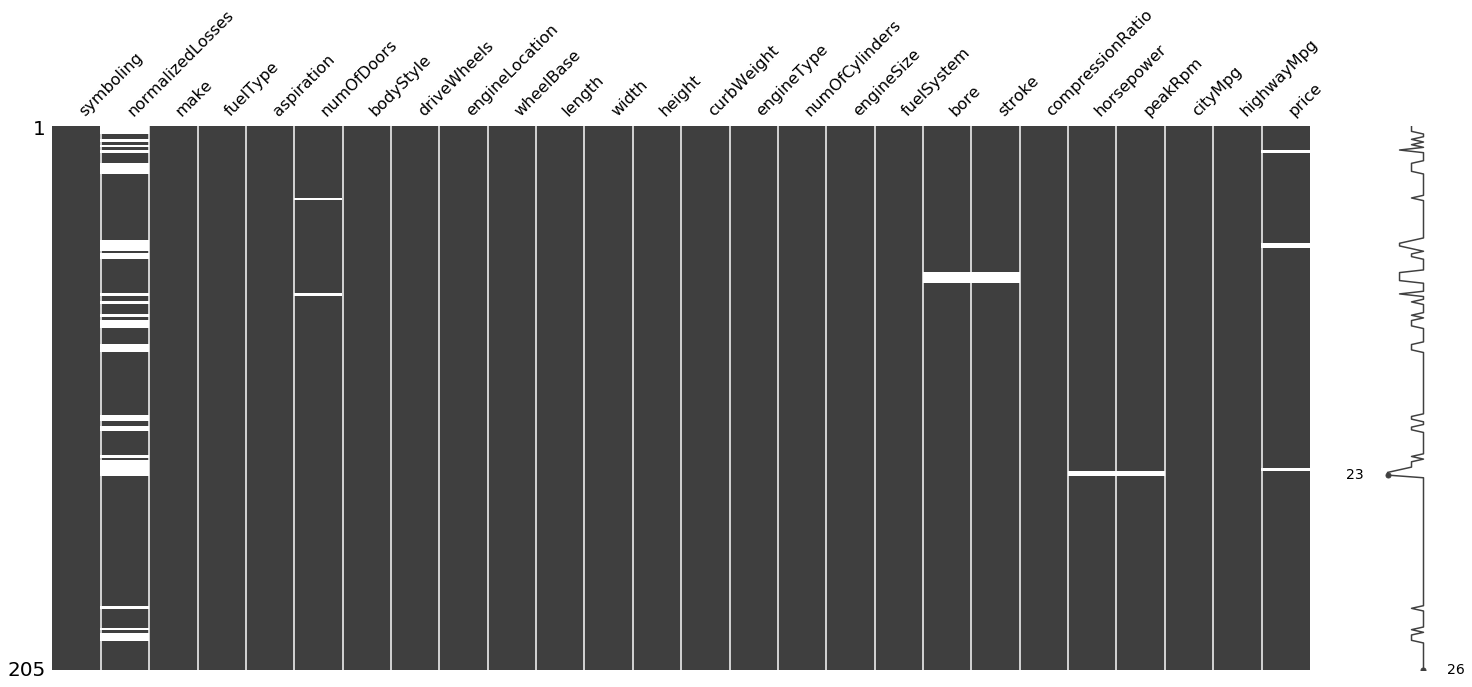

In [4]:
# show all na-Values
import missingno as msno
msno.matrix(df)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
symboling           205 non-null int64
normalizedLosses    164 non-null object
make                205 non-null object
fuelType            205 non-null object
aspiration          205 non-null object
numOfDoors          203 non-null object
bodyStyle           205 non-null object
driveWheels         205 non-null object
engineLocation      205 non-null object
wheelBase           205 non-null float64
length              205 non-null float64
width               205 non-null float64
height              205 non-null float64
curbWeight          205 non-null int64
engineType          205 non-null object
numOfCylinders      205 non-null object
engineSize          205 non-null int64
fuelSystem          205 non-null object
bore                201 non-null float64
stroke              201 non-null float64
compressionRatio    205 non-null float64
horsepower          203 non-null float64
peakRpm   

In [5]:
output_features = [
    "symboling"
]

input_features = [
    'normalizedLosses',
    'make',
    'fuelType',
    'aspiration',
    'numOfDoors',
    'bodyStyle',
    'driveWheels',
    'engineLocation',
    'wheelBase',
    'length',
    'width',
    'height',
    'curbWeight',
    'engineType',
    'numOfCylinders',
    'engineSize',
    'fuelSystem',
    'bore',
    'stroke',
    'compressionRatio',
    'horsepower',
    'peakRpm',
    'cityMpg',
    'highwayMpg',
    'price'
]

train_X, test_X, train_y, test_y = train_test_split(
    df[input_features], 
    df[output_features],
    test_size=0.2
)

In [6]:
train_X.shape, test_X.shape, train_y.shape, test_y.shape

((164, 25), (41, 25), (164, 1), (41, 1))

In [7]:
import numpy as np

def pretty_confusion(target, prediction):
    """Prettify the on-board confusion matrix of sklearn."""
    
    cmc = ["Condition positive", "Condition negative"]
    cmi = ["Predicted condition positive", "Predicted condition negative"]
    
    matrix = confusion_matrix(target, prediction)
    cm = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    return pd.DataFrame(cm , columns=cmc, index=cmi)


def debug_print(X, debug):
    """This method prints some debug information based on a debug parameter."""
    if not debug in ["input", "shape", "columns", False]:
        raise ValueError("Debug parameter value is not valied.")
    elif debug=="input":
        print(X.head(5))
    elif debug=="shape":
        print(X.shape)
    elif debug=="columns":
        print(X.columns)
    elif debug is False:
        pass

# Imputer
hier werden zunäcsht die Imputer für die fehlenden Werte gesetzt

In [8]:
class numOfDoorsImputer():
    
    """Imputs numOfDoor with modus of body-Style."""
    def __init__(self, debug=False):
        self.d = debug
        self.colnames = None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        debug_print(X=X, debug=self.d)
        #df = X.copy()

        df.numOfDoors = df.groupby(['bodyStyle'])['numOfDoors'].apply(lambda x: x.fillna(x.mode().iloc[0]))
        self.colnames = df.columns.tolist()
        return df
    
    def get_feature_names(self):
        return self.colnames 

In [9]:
class PriceImputer():
    """Imputs Price with median price of car-Brand."""

    def __init__(self, debug=False):
        self.d = debug
        self.colnames = None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        debug_print(X=X, debug=self.d)
        #df = X.copy()

        df.price = df.groupby(['make'])['price'].apply(lambda x: x.fillna(x.median()))
        self.colnames = df.columns.tolist()
        return df
    
    def get_feature_names(self):
        return self.colnames 

In [10]:
class boreStrokeImputer():
    """Imputs bore & Stroke with value of the next smaller engine size."""
    """Im gegebenen Datensatz sind die die Instanzen, welche nan/0/whatever in bore haben, die gleichen, die auch 
    missings in stroke haben. Auch wenn es gegen alle guten Sitten verstößt habe ich hier somit zwei feature zeitgleich upgedatet"""
    def __init__(self, debug=False):
        self.d = debug
        self.colnames = None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        debug_print(X=X, debug=self.d)
        #df = X.copy()
        ##########
        for i in range(0, len(df.stroke),1):
            if(str(df.stroke[i]) == "nan"):
                refferenceEngine = df.engineSize[i]
                possibleMachines = []
                for j in range(0, len(df),1):
                    if(df.engineSize[j]<refferenceEngine):
                        possibleMachines.append([j, df.engineSize[j], df.bore[j], df.stroke[j]])
                    else:
                        pass
                detectedValue=[possibleMachines[0]]# finde aus den möglichen Maschinen, die nächst kleinere im vgl zu unserem nan wert
                for j in range(0, len(possibleMachines),1):
                    if(int(detectedValue[0][1]) >= int(possibleMachines[j][1])):
                        pass
                    else:
                        detectedValue = [possibleMachines[j]]
                df.bore[i] = detectedValue[0][2]
                df.stroke[i] = detectedValue[0][3]
            
        ##########
        return df
    
    def get_feature_names(self):
        return self.colnames 


In [11]:
class hpPRPMImputer():
    """Imputs horspower & PRPM with value of the next smaller engine size."""
    """Im gegebenen Datensatz sind die die Instanzen, welche nan/0/whatever in HP haben, die gleichen, die auch 
    missings in PRPM haben. Auch wenn es gegen alle guten Sitten verstößt habe ich hier somit zwei feature zeitgleich upgedatet"""
    "'horsepower','peakRpm"
    
    def __init__(self, debug=False):
        self.d = debug
        self.colnames = None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        debug_print(X=X, debug=self.d)
        ##########
        for i in range(0, len(df.stroke),1):
            if(str(df.horsepower[i]) == "nan"):
                refferenceEngine = df.engineSize[i]
                possibleMachines = []
                for j in range(0, len(df),1):
                    if(df.engineSize[j]<refferenceEngine):
                        possibleMachines.append([j, df.engineSize[j], df.horsepower[j], df.peakRpm[j]])
                    else:
                        pass
                detectedValue=[possibleMachines[0]]# finde aus den möglichen Maschinen, die nächst kleinere im vgl zu unserem nan wert
                for j in range(0, len(possibleMachines),1):
                    if(int(detectedValue[0][1]) >= int(possibleMachines[j][1])):
                        pass
                    else:
                        detectedValue = [possibleMachines[j]]
                df.horsepower[i] = detectedValue[0][2]
                df.peakRpm[i] = detectedValue[0][3]
            
        ##########
        return df
    
    def get_feature_names(self):
        return self.colnames 


In [12]:
class OHE():
    
    """Imputs numOfDoor with modus of body-Style."""
    def __init__(self, debug=False):
        self.d = debug
        self.colnames = None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        debug_print(X=X, debug=self.d)
        listOfOHE=['make','fuelType','aspiration','numOfDoors','bodyStyle','driveWheels','engineLocation',
           'engineType','numOfCylinders', 'fuelSystem']
        for feature in range(0,len(listOfOHE),1):
            one_hot_encoder = OneHotEncoder()
            command = 'interim = one_hot_encoder.fit_transform(df.{}.values.reshape(-1,1))'.format(listOfOHE[feature])
            exec(command)
            interim = pd.DataFrame(interim.toarray(), columns=one_hot_encoder.categories_)
        return df
    
    def get_feature_names(self):
        return self.colnames 

# Feature-Union Tasks

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin
class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])

In [14]:
ts = TypeSelector("object")
ts.fit_transform(df).head()

,normalizedLosses,make,fuelType,aspiration,numOfDoors,bodyStyle,driveWheels,engineLocation,engineType,numOfCylinders,fuelSystem
0,NaN,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi
1,NaN,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi
2,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,ohcv,six,mpfi
3,164,audi,gas,std,four,sedan,fwd,front,ohc,four,mpfi
4,164,audi,gas,std,four,sedan,4wd,front,ohc,five,mpfi


In [15]:
from sklearn.pipeline import Pipeline
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("The DataFrame does not include the columns: %s" % cols_error)

In [16]:
cs = ColumnSelector(columns=["make", "engineSize"])
cs.fit_transform(df).head()

,make,engineSize
0,alfa-romero,130
1,alfa-romero,130
2,alfa-romero,152
3,audi,109
4,audi,136


# Pipe-Aufbau
ab hier werden die spezifika für die Pipeline erstellt

In [17]:
class FeatureSelector:
    """This transformer lets you pick columns from a pandas dataset based on name"""
    def __init__(self, features = [], debug=False):
        self.d = debug
        self.colnames = None
        if type(features) != list:
            raise ValueError("Input features must be of type List.")
        elif type(features) == list:
            self.columns = features

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        debug_print(X=X, debug=self.d)
        X = X[self.columns]
        self.colnames = X.columns.tolist()
        return X("numOfDoors_imputation", numOfDoorsImputer(debug=False)),bug
    
    def get_feature_names(self):
        return self.colnames

In [18]:
from sklearn.pipeline import Pipeline

class FeaturePipeline(Pipeline):
    def get_feature_names(self):
        return self.steps[-1][1].get_feature_names()

In [23]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

debug_state = False

pipe = FeaturePipeline(
    [

        ("price_imputation", PriceImputer(debug=False)),
        ("numOfDoors_imputation", numOfDoorsImputer(debug=False)),
        ("boreAndStroke_imputation", boreStrokeImputer(debug=False)),
        ("hpPRPM_imputation", hpPRPMImputer(debug=False)),
        ( FeatureUnion(
            transformer_list=[
                ("numeric_features", make_pipeline(
                    TypeSelector(np.number),
                    StandardScaler()
                )),
                ("categorical_features", make_pipeline(
                    TypeSelector("object"),
                    OneHotEncoder()
                ))
            ]
        ))
    ]
)

TypeError: zip argument #5 must support iteration

In [ ]:
from pipe_tools.pipe_visualizer import plot_pipeline
plot_pipeline(pipe, "pipeline_plot.png")

In [ ]:
print(train_X.stroke.isna().any())
train_X_prepared = pipe.transform(train_X)
print(train_X_prepared.stroke.isna().any())
print(type(train_X_prepared))


In [ ]:
# Einbau in die Pipeline

In [ ]:
listOfOHE=['make','fuelType','aspiration','numOfDoors','bodyStyle','driveWheels','engineLocation',
           'engineType','numOfCylinders', 'fuelSystem']
from sklearn.preprocessing import OneHotEncoder
for feature in range(0,len(listOfOHE),1):
    one_hot_encoder = OneHotEncoder()
    command = 'interim = one_hot_encoder.fit_transform(train_X_prepared.{}.values.reshape(-1,1))'.format(listOfOHE[feature])
    exec(command)
    interim = pd.DataFrame(interim.toarray(), columns=one_hot_encoder.categories_)
    train_X_prepared = pd.concat([train_X_prepared, interim], axis=1, sort=False)
    train_X_prepared = train_X_prepared.drop([listOfOHE[feature]], axis=1)
    

In [ ]:
import missingno as msno
msno.matrix(train_X_prepared)